In [108]:
## Here are some packages and modules that you will use. Make sure they are installed.

# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for modeling 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import plotly_express as px
import plotly.graph_objs as go

from imblearn.over_sampling import SMOTE

# to avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Import dataset

In [109]:
# Import dataset
df = pd.read_csv('uci-secom.csv') 
print("Dataframe shape:", df.shape) # Starting shape of dataset
print(df.head())


Dataframe shape: (1567, 592)
                  Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586

Visualize and Filter Data

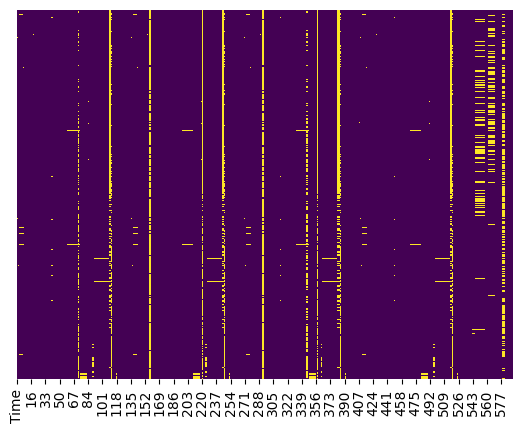

In [110]:
# Identify missing values and remove them
missing_values = df.isnull()
sns.heatmap(data = missing_values, yticklabels=False, cbar=False, cmap='viridis') # Visualize missing values
# df.dropna(axis=1, inplace=True) # Remove columns (axis=1) containing null values

feature_na_count = df.isna().sum() # Number of nan entries per feature
feature_na_count_hist = []
for idx, i in enumerate(df.columns): # For each feature
    for count in range(feature_na_count[idx]): # For number of missing entries
        feature_na_count_hist.append(i) # Append to histogram vector
px.histogram(data_frame=feature_na_count_hist, title="Distribution of NA Values by Feature") # Plot histogram
# px.bar(data_frame=na_count[1::], title="Histogram of NA Entries")


Remove Sparse Features

In [111]:
# Remove sparse features
orig_shape = df.shape # Original shape before dropping features
drop_count = 0 # Counter for number of features dropped
for idx, col in enumerate(df.columns):
    count_nan = df[col].isna().sum() # Determine number of missing entries for feature
    if count_nan > 100: # Check if feature is sparse (# missing entries > 100)
        df.drop(col, inplace=True, axis=1) # Drop feature if sparse
        drop_count += 1 # Increment drop feature counter

df.drop("Time", inplace=True, axis=1) # Drop 'Time' feature
drop_count += 1

print("# Features Dropped:", drop_count) # Output total number of features dropped
filtered_shape = df.shape 
print(filtered_shape) # Output new, filtered shape

# Features Dropped: 53
(1567, 539)


Remove Incomplete Data Points

In [112]:
# Determine number of rows with missing values
row_na_count = 0

for idx, row in enumerate(df.index):
    # print(idx, ":", df.loc[[idx]].isna().sum().sum()) 
    if df.loc[idx,:].isna().sum().sum() > 0:
        row_na_count += 1
        df.drop(labels=row, inplace=True, axis=0) # Drop rows containing 1 or more missing values

    # print(df[str(row)].value_counts(dropna=False))

print("Number of data points with missing information:", row_na_count)
print("Final shape of data frame:", df.shape)


Number of data points with missing information: 174
Final shape of data frame: (1393, 539)


In [113]:
# Replace pass/fail criteria in dataset
df = df.replace(-1, 0)
print(df.iloc[:,-1]) # Verify that all pass/fail entries are 1 (pass) or 0 (fail)


1       0
2       1
3       0
4       0
5       0
       ..
1537    0
1539    0
1540    0
1541    0
1550    0
Name: Pass/Fail, Length: 1393, dtype: int64


Test-Train Split

In [114]:
# Split data
# Split data into 'X' features and 'y' target label sets
X = df[df.columns[0:-1]]
# X = df.loc[:,:]
y = df[df.columns[-1]]
print(X)
# print(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# print([X_train, y_train])

            0        1          2          3       4      5         6       7  \
1     3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0  102.3433  0.1247   
2     2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
3     2988.72  2479.90  2199.0333   909.7926  1.3204  100.0  104.2367  0.1217   
4     3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0  100.3967  0.1235   
5     2946.25  2432.84  2233.3667  1326.5200  1.5334  100.0  100.3967  0.1235   
...       ...      ...        ...        ...     ...    ...       ...     ...   
1537  3006.22  2525.20  2192.7889  1268.5852  1.9935  100.0  104.5867  0.1268   
1539  2908.94  2560.99  2187.3444  2882.8558  1.5876  100.0   85.4189  0.1235   
1540  2996.04  2555.92  2190.7666  3530.2362  0.8017  100.0   83.8767  0.1249   
1541  3246.31  2499.79  2216.8111  1190.4067  2.5148  100.0  114.5533  0.1230   
1550  3072.20  2406.47  2195.4444  2914.1792  1.5978  100.0   85.1011  0.1235   

           8       9  ...  

Machine Learning: Logistic Regression Model

In [115]:
# Implement simple machine learning model
# print(df.iloc[:,1])
model_LR = LogisticRegression(max_iter=1000)
model_LR.fit(X=X_train, y=y_train)

c:\Users\Dhruv\anaconda3\envs\ML_T680\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(max_iter=1000)

Visualize Model Performance

In [116]:
predictions = model_LR.predict(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       904
           1       0.69      0.25      0.37        71

    accuracy                           0.94       975
   macro avg       0.82      0.62      0.67       975
weighted avg       0.93      0.94      0.92       975



In [117]:
# Create confusion matrix - Training dataset
cm_train = confusion_matrix(y_train, predictions)

# Plots the confusion matrix

## MATPLOTLIB
# plt.clf()
# plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.viridis)
# classNames = ['Negative','Positive']
# plt.title('Semiconductor Confusion Matrix')
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# tick_marks = np.arange(len(classNames))
# plt.xticks(tick_marks, classNames, rotation=45)
# plt.yticks(tick_marks, classNames)
# s = [['TN','FP'], ['FN', 'TP']]
# for i in range(2):
#     for j in range(2):
#         plt.text(j,i, str(s[i][j])+" = "+str(cm_train[i][j]))
# plt.show()


## PLOTLY
fig = px.imshow(cm_train, 
          title="Semiconductor Confusion Matrix <br><sup>Logistic Regression Model - Training Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()


In [118]:
# Create confusion matrix - Testing dataset
predictions = model_LR.predict(X_test)
print(classification_report(y_test, predictions))

cm_test = confusion_matrix(y_test, predictions)

## PLOTLY
fig = px.imshow(cm_test, 
          title="Semiconductor Confusion Matrix <br><sup>Logistic Regression Model - Testing Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       390
           1       0.11      0.07      0.09        28

    accuracy                           0.90       418
   macro avg       0.52      0.52      0.52       418
weighted avg       0.88      0.90      0.89       418



**Evaluation of LR Model Performance** \
The problem with applying a logistic regression model to this dataset is that it provides qualitative results with the underlying assumption that there is a linear relationship between the predictor features and the predicted dependent variable of pass/fail. As can be seen by the high prediction of false negative instances in the training and testing datasets, it is possible that this assumption of linearity is invalid. The model does provide value by establishing this assumption as invalid and letting the user know that there is not a linear relationship between the acquired features and the output of the semiconductor manufacturing process.

Random Forest Model

In [119]:
random_forest = RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=42)

scores_random_forest_train = cross_val_score(random_forest, X_train, y_train)
scores_random_forest_test = cross_val_score(random_forest, X_test, y_test)

random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=42)

In [120]:
print(f"Random forest classifier (train): "
      f"{scores_random_forest_train.mean():.3f} ± "
      f"{scores_random_forest_train.std():.3f}")

print(f"Random forest classifier (test): "
      f"{scores_random_forest_test.mean():.3f} ± "
      f"{scores_random_forest_test.std():.3f}")

predictions_train = random_forest.predict(X_train)
print(classification_report(y_train, predictions_train))

predictions_test = random_forest.predict(X_test)
print(classification_report(y_test, predictions_test))

Random forest classifier (train): 0.927 ± 0.002
Random forest classifier (test): 0.933 ± 0.005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       904
           1       1.00      0.99      0.99        71

    accuracy                           1.00       975
   macro avg       1.00      0.99      1.00       975
weighted avg       1.00      1.00      1.00       975

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       390
           1       0.00      0.00      0.00        28

    accuracy                           0.93       418
   macro avg       0.47      0.50      0.48       418
weighted avg       0.87      0.93      0.90       418



Normalize the Data

In [121]:
fig1 = px.histogram(X.mean(), title="Distribution of Feature Mean")

fig2 = px.histogram(X.std(), title="Distribution of Feature Standard Deviation")
fig1.xaxes()
fig1.show()
fig2.show()

AttributeError: 'Figure' object has no attribute 'xaxes'

Scaled Logistic Regression Pipeline

In [ ]:
# Define the model using Pipeline()
model_LR_Scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Fit the model
model_LR_Scaled.fit(X_train, y_train)
model_LR_Scaled.score(X_test, y_test)

Visualize Scaled LR Model

In [ ]:
# Create confusion matrix - Training dataset
predictions = model_LR_Scaled.predict(X_train)
print(classification_report(y_train, predictions))

cm_train = confusion_matrix(y_train, predictions)

## PLOTLY
### Training Dataset
fig = px.imshow(cm_train, 
          title="Semiconductor Confusion Matrix <br><sup>Scaled Logistic Regression Model - Training Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

In [ ]:
# Create confusion matrix - Testing dataset
predictions = model_LR_Scaled.predict(X_test)
print(classification_report(y_test, predictions))

cm_test = confusion_matrix(y_test, predictions)

## PLOTLY
### Testing Dataset
fig = px.imshow(cm_test, 
          title="Semiconductor Confusion Matrix <br><sup>Scaled Logistic Regression Model - Testing Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

Scaled Random Forest Pipeline

In [ ]:
# Define the model using Pipeline()
model_RF_Scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=42))
])

# Fit the model
model_RF_Scaled.fit(X_train, y_train)
model_RF_Scaled.score(X_test, y_test)

Visualized Scaled RF Model

In [ ]:
# Create confusion matrix - Training dataset
predictions = model_RF_Scaled.predict(X_train)
print(classification_report(y_train, predictions))

cm_train = confusion_matrix(y_train, predictions)

## PLOTLY
### Training Dataset
fig = px.imshow(cm_train, 
          title="Semiconductor Confusion Matrix <br><sup>Scaled Random Forest Model - Training Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

In [ ]:
# Create confusion matrix - Testing dataset
predictions = model_RF_Scaled.predict(X_test)
print(classification_report(y_test, predictions))

cm_test = confusion_matrix(y_test, predictions)

## PLOTLY
### Testing Dataset
fig = px.imshow(cm_test, 
          title="Semiconductor Confusion Matrix <br><sup>Scaled Random Forest Model - Testing Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

**Problem with Scaled Random Forest Model** \
The standard scaled RF model is overfit for the training data with only one false negative prediction and no false positives. For the testing dataset, there are no true positive predictions at all, indicating that the model is severely overfit and does not respond well to new data (i.e., testing dataset).

Feature Reduction for Logistic Regression (using PCA)

In [ ]:
## Logistic Regression

# Define the model using Pipeline()
model_LR_PCA = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=150, svd_solver='randomized', whiten=True).fit(X_train)),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Fit the model
model_LR_PCA.fit(X_train, y_train)
model_LR_PCA.score(X_test, y_test)

0.8851674641148325

In [ ]:
# Validate Training Performance

# Create confusion matrix - Training dataset
predictions = model_LR_PCA.predict(X_train)
print(classification_report(y_train, predictions))

cm_train = confusion_matrix(y_train, predictions)

## PLOTLY
### Training Dataset
fig = px.imshow(cm_train, 
          title="Semiconductor Confusion Matrix <br><sup>Scaled Logistic Regression Model w/ PCA - Training Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       904
           1       0.85      0.55      0.67        71

    accuracy                           0.96       975
   macro avg       0.91      0.77      0.82       975
weighted avg       0.96      0.96      0.96       975



In [ ]:
# Validate Testing Performance

# Create confusion matrix - Testing dataset
predictions = model_LR_PCA.predict(X_test)
print(classification_report(y_test, predictions))

cm_test = confusion_matrix(y_test, predictions)

## PLOTLY
### Testing Dataset
fig = px.imshow(cm_test, 
          title="Semiconductor Confusion Matrix <br><sup>Scaled Logistic Regression Model w/ PCA - Testing Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       390
           1       0.08      0.07      0.08        28

    accuracy                           0.89       418
   macro avg       0.51      0.51      0.51       418
weighted avg       0.88      0.89      0.88       418



Feature Reduction for Random Forest (using PCA)

In [ ]:
## Random Forest

# Define the model using Pipeline()
model_RF_PCA = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=150, svd_solver='randomized', whiten=True).fit(X_train)),
    ("classifier", RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=42))
])

# Fit the model
model_RF_PCA.fit(X_train, y_train)
model_RF_PCA.score(X_test, y_test)

0.9186602870813397

In [ ]:
# Validate Training Performance

# Create confusion matrix - Training dataset
predictions = model_RF_PCA.predict(X_train)
print(classification_report(y_train, predictions))

cm_train = confusion_matrix(y_train, predictions)

## PLOTLY
### Training Dataset
fig = px.imshow(cm_train, 
          title="Semiconductor Confusion Matrix <br><sup>Scaled Random Forest Model w/ PCA - Training Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       904
           1       1.00      0.96      0.98        71

    accuracy                           1.00       975
   macro avg       1.00      0.98      0.99       975
weighted avg       1.00      1.00      1.00       975



In [ ]:
# Validate Testing Performance

# Create confusion matrix - Testing dataset
predictions = model_RF_PCA.predict(X_test)
print(classification_report(y_test, predictions))

cm_test = confusion_matrix(y_test, predictions)

## PLOTLY
### Testing Dataset
fig = px.imshow(cm_test, 
          title="Semiconductor Confusion Matrix <br><sup>Scaled Random Forest Model w/ PCA - Testing Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       390
           1       0.12      0.04      0.06        28

    accuracy                           0.92       418
   macro avg       0.53      0.51      0.51       418
weighted avg       0.88      0.92      0.90       418



**Effect of PCA** \
Implementing PCA had a minimal to no effect as the performance of the model with PCA is similar to that of the scaled logistic regression model. For the random forest model, the performance was slightly better when compared to the scaled random forest model.

Hyperparameter Tuning

In [128]:
%%time

LR_GS = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("classifier", LogisticRegression(max_iter=1000))
])

LR_GS.fit(X_train, y_train)

param_grid = {
    'classifier__C': [0.001, .01, .1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': ['balanced'],
    'classifier__solver': ['saga'],
    'pca__n_components': [2, 3, 4, 5, 8, 10]
    }

LR_grid_search = GridSearchCV(estimator=LR_GS, param_grid=param_grid,
                                 n_jobs=2, cv=5, scoring='f1', verbose=10)

LR_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 406 ms
Wall time: 18.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=2,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__class_weight': ['balanced'],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['saga'],
                         'pca__n_components': [2, 3, 4, 5, 8, 10]},
             scoring='f1', verbose=10)

In [134]:
best_LR = LR_grid_search.best_estimator_

# Fit the model
best_LR.fit(X_train, y_train)
best_LR.score(X_test, y_test)

0.6866028708133971

In [135]:
# Validate Training Performance

# Create confusion matrix - Training dataset
predictions = best_LR.predict(X_train)
print(classification_report(y_train, predictions))

cm_train = confusion_matrix(y_train, predictions)

## PLOTLY
### Training Dataset
fig = px.imshow(cm_train, 
          title="Semiconductor Confusion Matrix <br><sup>Grid Search Logistic Regression Model - Training Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

              precision    recall  f1-score   support

           0       0.96      0.69      0.80       904
           1       0.14      0.62      0.22        71

    accuracy                           0.69       975
   macro avg       0.55      0.66      0.51       975
weighted avg       0.90      0.69      0.76       975



In [136]:
# Validate Testing Performance

# Create confusion matrix - Testing dataset
predictions = best_LR.predict(X_test)
print(classification_report(y_test, predictions))

cm_test = confusion_matrix(y_test, predictions)

## PLOTLY
### Testing Dataset
fig = px.imshow(cm_test, 
          title="Semiconductor Confusion Matrix <br><sup>Grid Search Logistic Regression Model - Testing Dataset</sup>", 
          text_auto=True, 
          labels=dict(x="Predicted Label", y="True Label", color="Scale"),
          x=['Negative', 'Positive'],
          y=['Negative', 'Positive'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600
)
fig.show()

              precision    recall  f1-score   support

           0       0.95      0.70      0.81       390
           1       0.11      0.50      0.18        28

    accuracy                           0.69       418
   macro avg       0.53      0.60      0.49       418
weighted avg       0.89      0.69      0.76       418

